In [35]:
import numpy as np
import matplotlib.pyplot as plt

# On the discretization schemes for the CIR (and Bessel squared) processes

In this notebook we study the paper from Aurélien Alfonsi in order to achieve a better simulation of the Heston model. Here we will dive in more detail on the construction of the model that will be used in other studies.

Here we will assume that:

$$
X_{t} = x_{0} + \int_{0}^{t}(a - k X_{s}) ds + \sigma \int_{0}^{t} \sqrt{X_{s}} dW_{s}
$$

We will also assume that $x_{0}, \sigma, a \geq 0$, $k\in\mathbb{R}$. Furthermore, to guarantee that the process is always positive, we will ensure the following conditions:

$$
2a > \sigma^{2} \quad \text{and} \quad x_{0} > 0
$$

We will denote $t_{i} = i \frac{T}{N}$, where $T$ is the total time of our simulation.

## Motivations

As mentioned in this paper, altough it is well known that we could simulate exactly the increments of the CIR process (non-central chi-squared random variables), we deal in other studies with processes that evolve with two correlated Brownian motions. Therefore simulating such as Glasserman, pp. 120-134 (Glasserman, P. (2003). Monte Carlo Methods in Financial Engineering *Springer, Series : Applications of Mathematics , Vol. 53*)

## Ways to simulate the process

### Euler-Maruyama scheme

$$
\hat{X}^{n}_{t_{i+1}} = \hat{X}^{n}_{t_{i}} + \frac{T}{n}(a - k\hat{X}^{n}_{t_{i}}) + \sigma\sqrt{\hat{X}^{n}_{t_{i}}}(W_{t_{i+1}} - W_{t_{i}}) 
$$

Main limitation of simulating in such a way is that we can reach negative values in our simulation.

In [3]:
def cir_euler_maruyama(k: float, a: float, sigma: float, x0: float, n: int, M: int, T: float) -> np.array:
    dt = T / n 

    dW = np.random.normal(0, np.sqrt(dt), (M, n))
    
    # Initialize the matrix to store the paths
    X = np.zeros((M, n+1))
    X[:, 0] = x0

    for i in range(n):
        X[:, i+1] = X[:, i] + dt * (a - k * X[:, i]) + sigma * np.sqrt(X[:, i]) * dW[:, i]

    return X

### Deelstra and Delbaen

$$
\hat{X}^{n}_{t_{i+1}} = \hat{X}^{n}_{t_{i}} + \frac{T}{n}(a - k\hat{X}^{n}_{t_{i}}) + \sigma\sqrt{\hat{X}^{n}_{t_{i}}\mathbf{1}_{\hat{X}^{n}_{t_{i}} > 0}}(W_{t_{i+1}} - W_{t_{i}}) 
$$

In [ ]:
def cir_deelstra_delbaen(k: float, a: float, sigma: float, x0: float, n: int, M: int, T: float) -> np.array:
    dt = T / n 

    dW = np.random.normal(0, np.sqrt(dt), (M, n))
    
    # Initialize the matrix to store the paths
    X = np.zeros((M, n+1))
    X[:, 0] = x0

    for i in range(n):
        X[:, i+1] = X[:, i] + dt * (a - k * X[:, i]) + sigma * np.sqrt(X[:, i]) * (X[:, i] > 0) * dW[:, i]

    return X

### Diop 

$$
\hat{X}^{n}_{t_{i+1}} = \left|\hat{X}^{n}_{t_{i}} + \frac{T}{n}(a - k\hat{X}^{n}_{t_{i}}) + \sigma\sqrt{\hat{X}^{n}_{t_{i}}}(W_{t_{i+1}} - W_{t_{i}})\right|
$$

In [ ]:
def cir_diop(k: float, a: float, sigma: float, x0: float, n: int, M: int, T: float) -> np.array:
    dt = T / n 

    dW = np.random.normal(0, np.sqrt(dt), (M, n))
    
    # Initialize the matrix to store the paths
    X = np.zeros((M, n+1))
    X[:, 0] = x0

    for i in range(n):
        X[:, i+1] = np.abs(X[:, i] + dt * (a - k * X[:, i]) + sigma * np.sqrt(X[:, i]) * dW[:, i])

    return X

### Implicit methods

We can use two different implicit methods in order to get the evolution of our process, the first by developping the $X$ and the other $X^{\frac{1}{2}}$.

For $X$:

$$
\hat{X}^{n}_{t_{i+1}} = \hat{X}^{n}_{t_{i}} + \left( a - \frac{\sigma^{2}}{2} -k \hat{X}^{n}_{t_{i+1}} \right) \frac{T}{n} + \sigma \sqrt{\hat{X}^{n}_{t_{i+1}}} (W_{t_{i+1}} - W_{t_{i}}) 
$$

Under the assumptions that $\hat{X}^{n}_{t_{i}} \geq 0$, $\frac{T}{n} \leq \frac{1}{k^{-}}$ (where $y^{-} = \text{max}(-y,0)$, which shall always be the case in the other notebooks since $k > 0$). The unque positive root of our equation is then:

$$
\hat{X}^{n}_{t_{i+1}} = \left( \frac{\sigma (W_{t_{i+1}} - W_{t_{i}}) + \sqrt{\sigma^{2}(W_{t_{i+1}} - W_{t_{i}})^{2} + 4(\hat{X}^{n}_{t_{i}} + (a - \frac{\sigma^{2}}{2}) \frac{T}{n}) (1 + k\frac{T}{n}) }}{2(1 + k\frac{T}{n})} \right)^{2}
$$

For $\sqrt{X}$:

$$
d\sqrt{X_{t}} = \frac{a-\frac{\sigma^{2}}{4}}{2\sqrt{X_{t}}}dt - \frac{k}{2} \sqrt{X_{t}} dt + \frac{\sigma}{2} dW_{t}
$$

Which gives:

$$
\left(1 + \frac{kT}{2n}\right)X^{n}_{t_{i}} - \left[\frac{\sigma}{2} (W_{t_{i+1}} - W_{t_{i}}) + \sqrt{X^{n}_{t_{i}}} \right]X^{n}_{t_{i+1}} - \frac{a - \frac{\sigma^{2}}{4}}{2}\frac{T}{n} = 0
$$

Having as solution:

$$
\hat{X}^{n}_{t_{i+1}} = \left( \frac{ \frac{\sigma}{2}(W_{t_{i+1}} - W_{t_{i}}) + \sqrt{\hat{X}^{n}_{t_{i}}} +\sqrt{(\frac{\sigma}{2}(W_{t_{i+1}} - W_{t_{i}}) + \sqrt{\hat{X}^{n}_{t_{i}}})^{2} + 4 \left(1 + \frac{kT}{2n}\right)\frac{a - \frac{\sigma^{2}}{4}}{2}\frac{T}{n}}}{2\left(1 + \frac{kT}{2n}\right)} \right)^{2}
$$

In [31]:
def implicit_diffusion(k: float, a: float, sigma: float, x0: float, n: int, M: int, T: float) -> np.array:
    dW = np.random.normal(0, np.sqrt(T/n), (M, n))
    X = np.zeros((M, n+1))
    X[:, 0] = x0
    
    for i in range(n):
        X[:, i+1] = ((sigma * dW[:, i] + np.sqrt(sigma**2 * dW[:, i]**2 + 4 * (X[:, i] + (a - 0.5*sigma**2) * (T/n)) * (1 + k * (T/n)))) / (2 * (1 + k * (T/n))))**2

    return X

def implicit_drift(k: float, a: float, sigma: float, x0: float, n: int, M: int, T: float) -> np.array:
    dW = np.random.normal(0, np.sqrt(T/n), (M, n))
    X = np.zeros((M, n+1))
    X[:, 0] = x0
    
    for i in range(n):
        X[:, i+1] = ((sigma/2 * dW[:, i] + np.sqrt(X[:, i]) + np.sqrt((sigma/2 * dW[:, i] + np.sqrt(X[:, i]))**2 + 4 * (1 + k * T/(2*n)) * (a - sigma**2/4) * T/(n))) / (2 * (1 + k * T/(2*n))))**2

    return X

## Visualizing curves

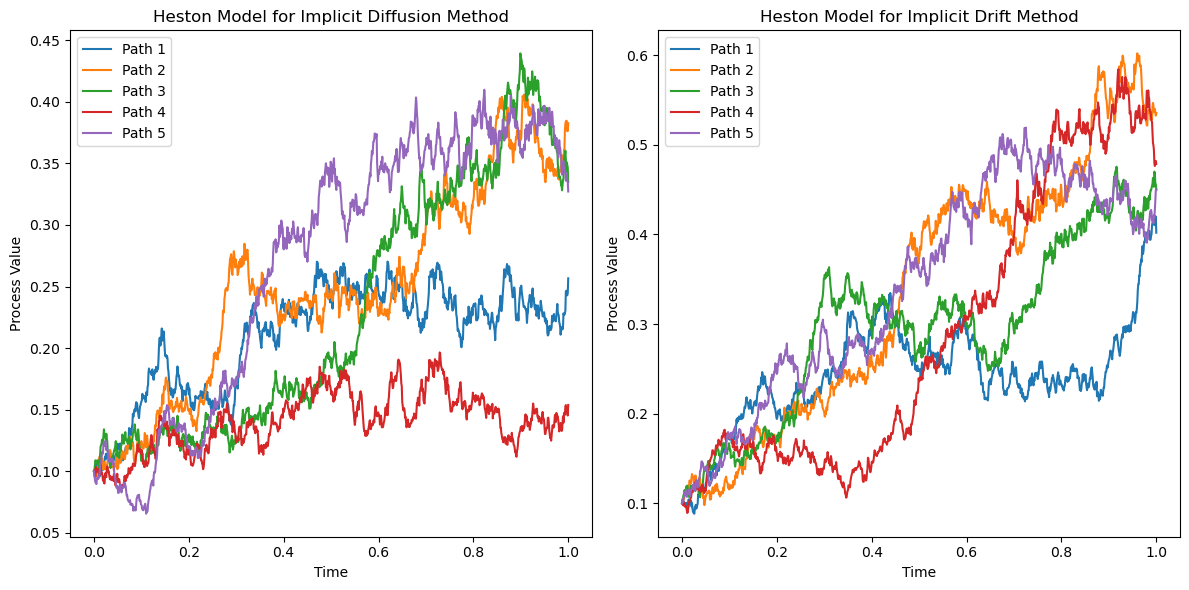

In [49]:
# Parameters
k = 0.1
a = 0.2
sigma = 0.3
x0 = 0.10
n = 1000
M = 5
T = 1.0

plt.figure(figsize = (12,6))

# Simulate process - Implicit diffusion method
paths_diffusion = implicit_diffusion(k, a, sigma, x0, n, M, T)

# Plot the paths - Implicit diffusion method
time_grid = np.linspace(0, T, n+1)
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
for i in range(M):
    plt.plot(time_grid, paths_diffusion[i, :], label=f"Path {i+1}")

plt.xlabel("Time")
plt.ylabel("Process Value")
plt.title("Heston Model for Implicit Diffusion Method")
plt.legend()

# Simulate process - Implicit drift method
paths_drift = implicit_drift(k, a, sigma, x0, n, M, T)

# Plot the paths - Implicit drift method
time_grid = np.linspace(0, T, n+1)
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
for i in range(M):
    plt.plot(time_grid, paths_drift[i, :], label=f"Path {i+1}")

plt.xlabel("Time")
plt.ylabel("Process Value")
plt.title("Heston Model for Implicit Drift Method")
plt.legend()

plt.tight_layout()  # Adjust layout for better spacing
plt.show()
